In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk import FreqDist
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\jw517\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
news=pd.read_csv('news.csv')

In [3]:
news.head()

,Title,Date,Press,Topic,Text
0,Newt Gingrich: Democrats prove they are the 'L...,2020-09-01,Fox,2020 Presidential Election,Fox News Flash top entertainment and celebrity...
1,Ed Rollins says election could come down to Wi...,2020-09-01,Fox,2020 Presidential Election,White House Strategic Communications Director ...
2,Anti-Trump Lincoln Project launches coalition ...,2020-09-01,Fox,ELECTIONS,"House Minority Leader Kevin McCarthy, R-Calif...."
3,Biden’s tough tone on riots comes amid attacks...,2020-09-01,Fox,ELECTIONS,Steve Hilton highlights President Trump's fulf...
4,NY attorney general files injunction to stop T...,2020-09-02,Fox,ELECTIONS,President Trump holds a ‘Making America Great ...


In [4]:
news['Date']=pd.to_datetime(news['Date'])
date_rng = pd.date_range('2020-08-27', periods = 10, freq='W')
news['Week']=pd.cut(news.Date, bins=date_rng, right=False)

In [5]:
news=news[(news['Date']!='2020-11-01')&(news['Date']!='2020-11-02')]

In [6]:
news.Press.unique()

array(['Fox', 'NPR', 'Reuters', 'CBS', 'Politico'], dtype=object)

In [7]:
Fox=news[news.Press=='Fox']
RN=news[(news.Press=='Reuters')|(news.Press=='NPR')]
CP=news[(news.Press=='CBS')|(news.Press=='Politico')]

In [8]:
Fox['MB']='Right'
RN['MB']='Center'
CP['MB']='Left'

C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [9]:
news=pd.concat([Fox,RN,CP],ignore_index=True)

In [10]:
news.Text=news.Text.str.lower()

In [11]:
news.Text=news.Text.str.replace('\xa0@|\xa0',' ')
news.Text=news.Text.str.replace("\|\n|\'"," ")
news.Text=news.Text.str.strip()

In [12]:
shortword = re.compile(r'\W*\b\w{1,2}\b')
news.Text=news.Text.str.replace(shortword,'')

In [13]:
# stop_words = set()
lis=stopwords.words('english')

In [14]:
def stopword(x):
    stop_words = set(stopwords.words('english')) 
    result = []
    for i in x: 
        if i not in stop_words: 
            result.append(i)
    return result

def Pstem(x):
    s=PorterStemmer()
    return [s.stem(w) for w in x]

def Lstem(x):
    l=LancasterStemmer()
    return [l.stem(w) for w in x]

def trump(x):
    return x['trump']

def biden(x):
    return x['biden']


In [15]:
eng=re.compile('[a-zA-Z0-9]+')
news.Text.str.findall(eng)[0:10].apply(stopword)

0    [fox, news, flash, top, entertainment, celebri...
1    [white, house, strategic, communications, dire...
2    [house, minority, leader, kevin, mccarthy, cal...
3    [steve, hilton, highlights, president, trump, ...
4    [president, trump, holds, making, america, gre...
5    [former, arkansas, gov, mike, huckabee, discus...
6    [trump, 2020, campaign, senior, adviser, gives...
7    [former, house, speaker, breaks, vice, preside...
8    [cain, latest, fox, bet, super, contest, fox, ...
9    [five, discusses, president, democratic, nomin...
Name: Text, dtype: object


# 1


In [16]:
news['trump_count']=news.Text.str.findall(eng).apply(stopword).apply(FreqDist).apply(trump)
news['biden_count']=news.Text.str.findall(eng).apply(stopword).apply(FreqDist).apply(biden)

In [17]:
count=news.groupby(['MB'])[['trump_count','biden_count']].sum()

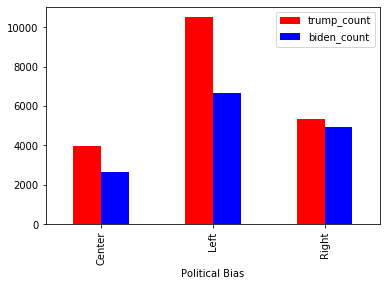

In [19]:
g=count.plot(kind='bar',xlabel='Political Bias',color=('r','b'))


## 2


In [20]:
# 일별 후보자 언급 빈도수

In [21]:
date_count=news.groupby(['Date'])[['trump_count','biden_count']].sum()
date_count=date_count.T
date_count['name']=['Trump','Biden']

In [22]:
a=list(range(1,31))
b=list((range(1,32)))
col=a+b
col[0]='9/1'
col[30]='10/1'
col.append('name')
date_count.columns=col

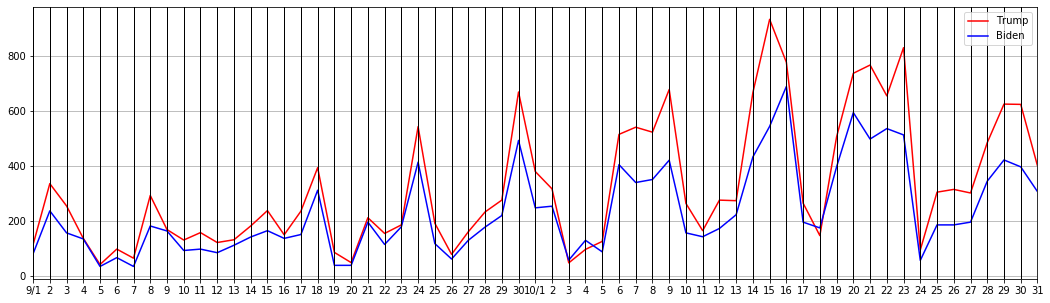

In [23]:
from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(18,5))
parallel_coordinates(date_count,'name',color=('r','b'),ax=ax)
plt.savefig('frequency1.png',transparent=True)
plt.show()

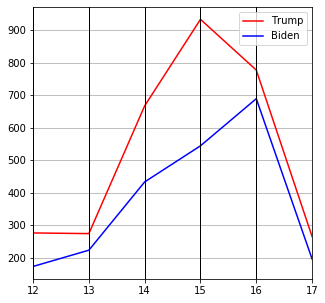

In [24]:
date_count_issue=date_count[[12,13,14,15,16,17]].iloc[:,[1,3,5,7,9,11]]
date_count_issue['name']=['Trump','Biden']

from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(5,5))
parallel_coordinates(date_count_issue,'name',color=('r','b'),ax=ax)
plt.savefig('frequency11.png',transparent=True)
plt.show()

In [25]:
# 기간별 후보자 언급 빈도수

In [26]:
date_rng

DatetimeIndex(['2020-08-30', '2020-09-06', '2020-09-13', '2020-09-20',
               '2020-09-27', '2020-10-04', '2020-10-11', '2020-10-18',
               '2020-10-25', '2020-11-01'],
              dtype='datetime64[ns]', freq='W-SUN')

In [286]:
week_count=news.groupby(['Week'])[['trump_count','biden_count']].sum()
week_count=week_count.T

In [287]:
c=list(range(1,10))
week_count.columns=list(map(lambda x:str(x)+' period',c))

In [288]:
week_count['name']=['Trump','Biden']

In [289]:
col=['1 period', '2 period', '3 period', '4 period', '5 period', '6 period',
       '7 period', '8 period','name']

In [290]:
week_count.name

trump_count    Trump
biden_count    Biden
Name: name, dtype: object

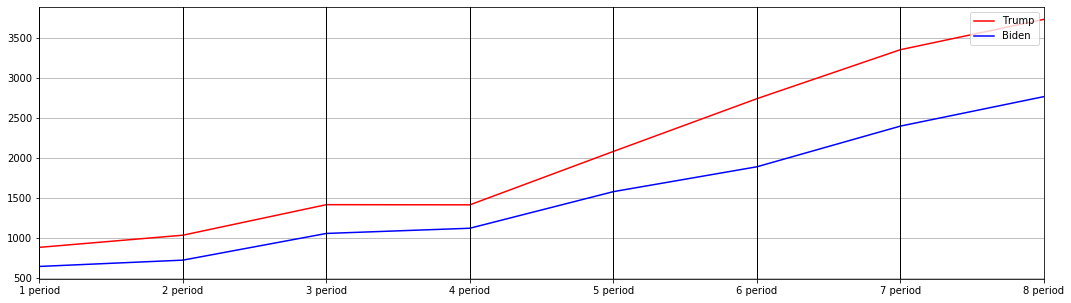

In [291]:
from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(18,5))
parallel_coordinates(week_count[col],'name',color=('r','b'),ax=ax)

plt.savefig('whole_fre.png',transparent=True)
plt.show()

In [292]:
#언론사별 후보자 언급 빈도수

In [293]:
mb_count=news.groupby(['MB','Week'])[['trump_count','biden_count']].sum()
mb_count=mb_count.T

In [294]:
center=mb_count['Center']
right=mb_count['Right']
left=mb_count['Left']

In [295]:
c=list(range(1,10))
center.columns=list(map(lambda x:str(x)+' period',c))
right.columns=list(map(lambda x:str(x)+' period',c))
left.columns=list(map(lambda x:str(x)+' period',c))

In [296]:
center['name']=['Trump','Biden']
right['name']=['Trump','Biden']
left['name']=['Trump','Biden']

C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jw517\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [297]:
center

,1 period,2 period,3 period,4 period,5 period,6 period,7 period,8 period,9 period,name
trump_count,228,271,374,281,535,652,442,525,678,Trump
biden_count,131,108,274,213,331,406,369,375,467,Biden


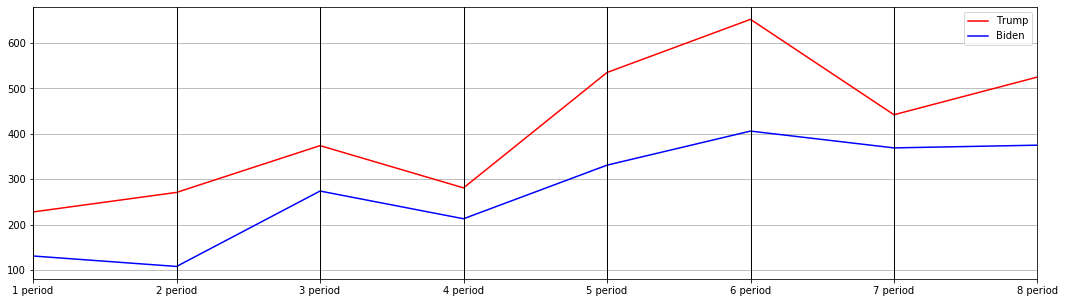

In [298]:
from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(18,5))
parallel_coordinates(center[col],'name',color=('r','b'),ax=ax)
plt.savefig('center_fre.png',transparent=True)
plt.show()

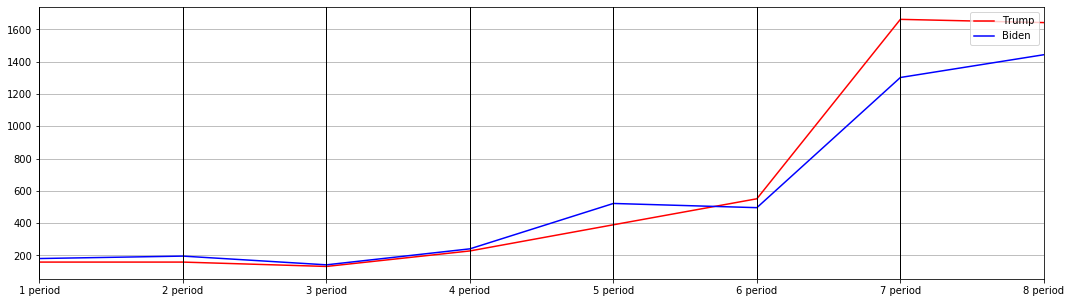

In [299]:
from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(18,5))
parallel_coordinates(right[col],'name',color=('r','b'),ax=ax)
plt.savefig('right_fre.png',transparent=True)
plt.show()

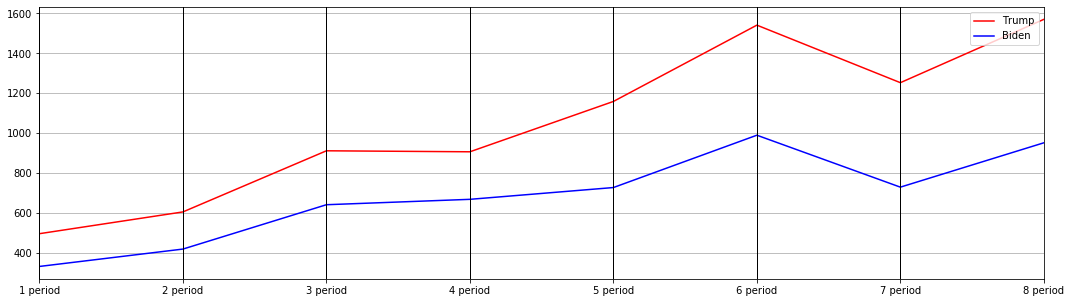

In [301]:
from pandas.plotting import parallel_coordinates

fig,ax=plt.subplots(1,1,figsize=(18,5))
parallel_coordinates(left[col],'name',color=('r','b'),ax=ax)
plt.savefig('left_fre.png',transparent=True)
plt.show()


## 3


In [56]:
news['Token']=news.Text.str.findall(eng).apply(stopword)

In [223]:
def upper(x):
    y=[]
    for i in x:
        if i=='trump':
            i='Trump'
        if i=='biden':
            i='Biden'
        y.append(i)
    return y

def join(x):
    return " ".join(x)

def proper_lemmatize(x):
    WL = WordNetLemmatizer()
    lis=[]
    for word,tag in x:
        if tag[0]=='V':
            lis.append(WL.lemmatize(word,'v'))
        elif tag[0]=='J':
            lis.append(WL.lemmatize(word,'a'))
        elif tag[0]=='NNP':
            lis.append(word)
        else:
            lis.append(WL.lemmatize(word))
    return lis

def byebye(x):
    bye=["would", "election", "could", "also", "president",
     "vote", "voter", "house", "run", "two", "rox", 
     "reuters","way","go", "point", "take", "say","Biden",'Trump','think','fox']
    stop_words = bye
    result = []
    for i in x: 
        if i not in stop_words: 
            result.append(i)
    return result

In [58]:
news['tag']=news.Token.apply(upper).apply(pos_tag)

In [225]:
news['Text_A']=news['tag'].apply(proper_lemmatize).apply(byebye).apply(join)

In [226]:
tf=TfidfVectorizer(min_df=2)
tf.fit(news.Text_A)

TfidfVectorizer(min_df=2)

In [227]:
news_week=news.groupby(['Week'])['Text_A'].sum()

In [228]:
news_week

Week
[2020-08-30, 2020-09-06)    news flash top entertainment celebrity headlin...
[2020-09-06, 2020-09-13)    former 2016 campaign advisor steve moore forme...
[2020-09-13, 2020-09-20)    romney 2012 policy director lanhee chen news c...
[2020-09-20, 2020-09-27)    former vice discus healthcare plan final debat...
[2020-09-27, 2020-10-04)    data show nearly million cast already bret bai...
[2020-10-04, 2020-10-11)    senator question amy coney barrett stance affo...
[2020-10-11, 2020-10-18)    vice presidential debate vice mike penny democ...
[2020-10-18, 2020-10-25)    2020 deputy communication director matt wolkin...
[2020-10-25, 2020-11-01)    news flash top headline check click foxnews co...
Name: Text_A, dtype: object

In [229]:
news_Date=news.groupby(['Date'])['Text_A'].sum()

In [230]:
news_Date

Date
2020-09-01    news flash top entertainment celebrity headlin...
2020-09-02    hold make america great rally newtown democrat...
2020-09-03    rep john garamendi weigh state campaign three ...
2020-09-04    former clinton white deputy assistant matt ben...
2020-09-05    2020 presidential create wave across pond resi...
                                    ...                        
2020-10-27    news flash top headline check click foxnews co...
2020-10-28    rnc chair ronna mcdaniel compare campaign team...
2020-10-29    democrat try maximize severity coronavirus shu...
2020-10-30    senior editor federalist news contributor moll...
2020-10-31    call report atlantic disgraceful situation ter...
Name: Text_A, Length: 61, dtype: object


# 4


In [231]:
#전체 키워드 top 10

In [232]:
!pip install squarify

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\Users\jw517\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [234]:
whole_keyword=tf.transform(news_week).toarray().sum(axis=0).argsort()[::-1]
result=[]
voca={j:i for i,j in tf.vocabulary_.items()}
for j in whole_keyword[:10]:
    result.append(voca[j])

whole=pd.DataFrame(result)

In [235]:
whole['rank']=sorted(tf.transform(news_week).toarray().sum(axis=0))[::-1][:10]

In [236]:
whole

,0,rank
0,state,1.447205
1,ballot,1.095828
2,campaign,1.075736
3,debate,1.049254
4,percent,1.028441
5,poll,1.008085
6,woman,0.983005
7,republican,0.918396
8,year,0.814315
9,court,0.799527


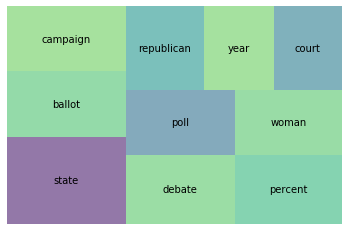

In [237]:
import squarify

squarify.plot(sizes=whole['rank'], label=whole[0],alpha=.59)
plt.axis('off')
plt.savefig('ww.jpg')
plt.show();

In [238]:
### 주간 키워드 top10

In [239]:
def voca_top10(x):
    result=[]
    voca={j:i for i,j in tf.vocabulary_.items()}

    for i in x:
        result1=[]
        i=i[::-1]
        for j in i[:10]:
            result1.append(voca[j])
        result.append(result1)
    return result

In [240]:
keyword=tf.transform(news_week).toarray().argsort()
we=pd.DataFrame(voca_top10(keyword),index=news_week.index)

ind=['1 period', '2 period', '3 period', '4 period', '5 period', '6 period',
       '7 period', '8 period','name']
col=['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

we.index=ind
we.columns=col
we=we.iloc[:-1]

In [ ]:
# 전체 키워드에 대한 카테고리별 top10

In [ ]:
def whole_top(ranking,data):
    dic={}
    
    voca={j:i for i,j in tf.vocabulary_.items()}
    array=tf.transform(data).toarray()
    
    for i in whole_keyword[0:ranking]:
        tfidf=[]
        for num in range(len(data)):
            tfidf.append(array[num][i])
        dic[voca[i]]=tfidf
    df=pd.DataFrame(dic)
    return df.T

In [ ]:
whole_top(10,news_week)


# 5


In [ ]:
def J(x):
    WL = WordNetLemmatizer()
    lis=[]
    for word,tag in x:
        if tag[0]=='J':
            lis.append(WL.lemmatize(word,'a'))
        else:
            pass
    return lis

In [ ]:
news['Text_B']=news['tag'].apply(J).apply(join)

In [ ]:
tfB=TfidfVectorizer(min_df=2)
tfB.fit(news.Text_B)

In [ ]:
MB_date_b=news.groupby(['MB','Date'])['Text_B'].sum()

In [ ]:
lb=MB_date_b['Left']

In [ ]:
['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']

In [ ]:
lba=tfB.transform(lb).toarray().argsort()

In [242]:
def voca_top10(x):
    result=[]
    voca={j:i for i,j in tfB.vocabulary_.items()}

    for i in x:
        result1=[]
        i=i[::-1]
        for j in i[:30]:
            result1.append(voca[j])
        result.append(result1)
    return result

In [243]:
pd.DataFrame(voca_top10(lba),index=lb.index).loc[['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-12,ufc,final,fivethirtyeight,average,progressive,qanon,many,gop,democratic,international,...,dnc,good,green,national,social,civil,similar,young,new,pro
2020-10-13,colombian,likely,aerial,colombia,stein,canada,new,united,manual,electoral,...,technological,presidential,percent,high,public,monday,trudeau,precinct,chinese,nba
2020-10-14,ufc,final,colombian,alberta,early,many,last,electoral,fivethirtyeight,average,...,win,close,large,danny,aerial,colombia,diaz,republican,florida,long
2020-10-15,early,republican,cbs,ufc,many,last,texas,new,final,democratic,...,electoral,least,positive,florida,first,recent,political,real,likely,pandemic
2020-10-16,ufc,early,final,colombian,electoral,percent,alberta,last,average,many,...,good,much,close,former,long,north,progressive,qanon,win,little



# 6


In [244]:
whole_keyword=tf.transform(news_Date).toarray()

In [245]:
df=pd.DataFrame(whole_keyword,index=news_Date.index)

In [246]:
whole_keyword=df.loc[['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']].sum(axis=0)

In [247]:
res=whole_keyword.argsort()[::-1]

In [248]:
result=[]
voca={j:i for i,j in tf.vocabulary_.items()}
for j in res[:10]:
    result.append(voca[j])

pd.DataFrame(result)

,0
0,state
1,ballot
2,debate
3,campaign
4,county
5,poll
6,get
7,qanon
8,one
9,day


In [249]:
news_MB=news.groupby(['MB','Date'])['Text_A'].sum()

In [250]:
Left=tf.transform(news_MB['Left']).toarray()
Right=tf.transform(news_MB['Right']).toarray()
Center=tf.transform(news_MB['Center']).toarray()

In [251]:
Center

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0365943 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00999249, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04170571, 0.00746043, 0.        , ..., 0.        , 0.02079095,
        0.        ],
       [0.03202546, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03783631, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [252]:
df_left=pd.DataFrame(Left,index=news_MB['Left'].index)
df_right=pd.DataFrame(Right,index=news_MB['Right'].index)
df_center=pd.DataFrame(Center,index=news_MB['Center'].index)

In [253]:
df_center.head()

,0,1,2,3,4,5,6,7,8,9,...,13254,13255,13256,13257,13258,13259,13260,13261,13262,13263
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-02,0.036594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-03,0.009992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-04,0.019661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-05,0.025947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [254]:
left_df=df_left.loc[['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']].sum()
left=left_df.argsort()[::-1]
right_df=df_right.loc[['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']].sum()
right=right_df.argsort()[::-1]
center_df=df_right.loc[['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']].sum()
center=center_df.argsort()[::-1]

In [255]:
left_df.iloc[9601]

0.0

In [256]:
voca={j:i for i,j in tf.vocabulary_.items()}
voca[9601]
left

13263     9600
13262    11325
13261      765
13260     3066
13259     1423
         ...  
4         5913
3         5914
2        10620
1         5916
0        13263
Length: 13264, dtype: int64

In [257]:
#right 키워드 ['2020-10-12', '2020-10-13', '2020-10-14','2020-10-15', '2020-10-16']

result={'Keyword':[],'Right':[],'Left':[],'Center':[]}

voca={j:i for i,j in tf.vocabulary_.items()}
for j in left[:10]:
    result['Keyword'].append(voca[j])
    result['Right'].append(right_df[j])
    result['Left'].append(left_df[j])
    result['Center'].append(center_df[j])
    
pd.DataFrame(result)

,Keyword,Right,Left,Center
0,qanon,0.010612,0.779065,0.010612
1,state,0.613343,0.726049,0.613343
2,alberta,0.007985,0.649334,0.007985
3,county,0.214052,0.609735,0.214052
4,ballot,0.574025,0.583473,0.574025
5,colombia,0.000000,0.517503,0.000000
6,poll,0.302133,0.510972,0.302133
7,percent,0.053893,0.504034,0.053893
8,ufc,0.000000,0.503536,0.000000
9,recount,0.003822,0.462645,0.003822


In [258]:
re=pd.DataFrame(result)

In [259]:
result=[]
voca={j:i for i,j in tf.vocabulary_.items()}
for j in right[:10]:
    result.append(voca[j])

re_right=pd.DataFrame(result)

In [260]:
result=[]
voca={j:i for i,j in tf.vocabulary_.items()}
for j in left[:10]:
    result.append(voca[j])

re_left=pd.DataFrame(result)

In [261]:
re

,Keyword,Right,Left,Center
0,qanon,0.010612,0.779065,0.010612
1,state,0.613343,0.726049,0.613343
2,alberta,0.007985,0.649334,0.007985
3,county,0.214052,0.609735,0.214052
4,ballot,0.574025,0.583473,0.574025
5,colombia,0.000000,0.517503,0.000000
6,poll,0.302133,0.510972,0.302133
7,percent,0.053893,0.504034,0.053893
8,ufc,0.000000,0.503536,0.000000
9,recount,0.003822,0.462645,0.003822



# 7


In [262]:
lis=[]
for i in range(0,10):
    j=0.08*i
    lis.append(j)
lis

[0.0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72]

In [263]:
re['num']=lis

In [279]:
fig = go.Figure(data=
    go.Parcoords(
        line_color='red',
        dimensions = list([
             dict(range = [0,0.8],
                 tickvals = lis,
                 label = 'Keyword', values = lis,
                 constraintrange = [0.07,0.08],
                 ticktext = re.Keyword.tolist()[::-1]),
            
            dict(range = [0,0.8],
                 label = re.columns[2], values = re['Left'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[1], values = re['Right'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[3], values = re['Center'].tolist()[::-1])
        ])
    )
)

fig.show()

<Figure size 432x288 with 0 Axes>

In [280]:
fig = go.Figure(data=
    go.Parcoords(
        line_color='red',
        dimensions = list([
             dict(range = [0,0.8],
                 tickvals = lis,
                 label = 'Keyword', values = lis,
                 constraintrange = [0.7,0.8],
                 ticktext = re.Keyword.tolist()[::-1]),
            
            dict(range = [0,0.8],
                 label = re.columns[2], values = re['Left'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[1], values = re['Right'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[3], values = re['Center'].tolist()[::-1])
        ])
    )
)

fig.show()

<Figure size 432x288 with 0 Axes>

In [278]:
fig = go.Figure(data=
    go.Parcoords(
         line = dict(color = re['num'],
                   colorscale = [[0,'gold'],[0.5,'lightseagreen'],[1,'purple']]),
        dimensions = list([
             dict(range = [0,0.8],
                 tickvals = lis,
                 label = 'Keyword', values = lis,
                 ticktext = re.Keyword.tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[2], values = re['Left'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[1], values = re['Right'].tolist()[::-1]),
            dict(range = [0,0.8],
                 label = re.columns[3], values = re['Center'].tolist()[::-1])
        ])
    )
)


fig.show()

In [268]:
re_right['num']=[10,9,8,7,6,5,4,3,2,1]
re_right['rank']=['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

re_left['num']=[10,9,8,7,6,5,4,3,2,1]
re_left['rank']=['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

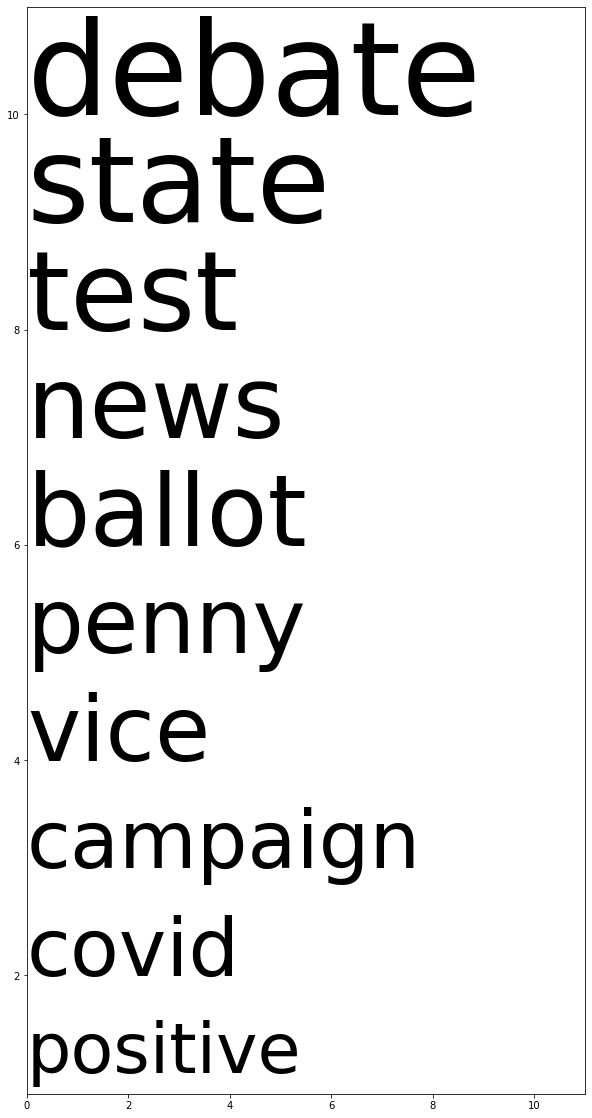

In [273]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,20))
plt.axis([0, 11, 0.9, 11])
plt.text(0, 10, re_right[0][0], fontsize=130,)
plt.text(0, 9, re_right[0][1], fontsize=120,)
plt.text(0, 8, re_right[0][2], fontsize=110,)
plt.text(0, 7, re_right[0][3], fontsize=100,)
plt.text(0, 6, re_right[0][4], fontsize=100,)
plt.text(0, 5, re_right[0][5], fontsize=90,)
plt.text(0, 4, re_right[0][6], fontsize=90,)
plt.text(0, 3, re_right[0][7], fontsize=80,)
plt.text(0, 2, re_right[0][8], fontsize=80,)
plt.text(0, 1.1, re_right[0][9], fontsize=70,)

plt.savefig('right_word.jpg')
plt.show()


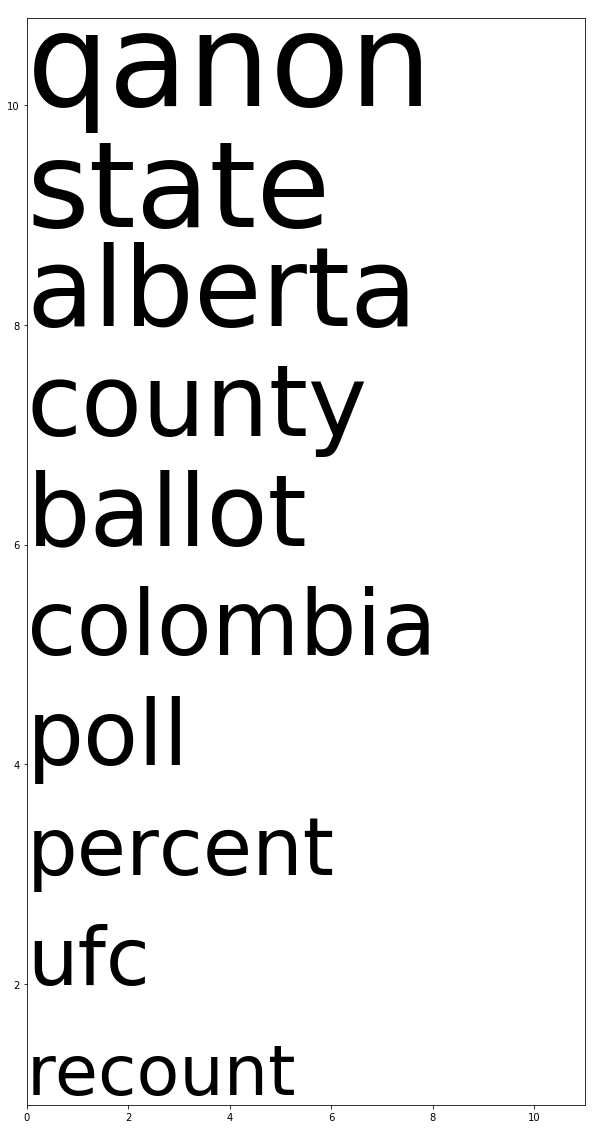

In [271]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,20))
plt.axis([0, 11, 0.9, 10.8])
plt.text(0, 10, re_left[0][0], fontsize=130,)
plt.text(0, 8.9, re_left[0][1], fontsize=120,)
plt.text(0, 8, re_left[0][2], fontsize=110,)
plt.text(0, 7, re_left[0][3], fontsize=100,)
plt.text(0, 6, re_left[0][4], fontsize=100,)
plt.text(0, 5, re_left[0][5], fontsize=90,)
plt.text(0, 4, re_left[0][6], fontsize=90,)
plt.text(0, 3, re_left[0][7], fontsize=80,)
plt.text(0, 2, re_left[0][8], fontsize=80,)
plt.text(0, 1, re_left[0][9], fontsize=70,)

plt.savefig('left_word.jpg')
plt.show()
